# Cost Minimization

Below we start with a basic example of a hybrid variational algorithm which involves flipping the Bloch vector of a qubit from the $\ket{0}$ to the $\ket{1}$ state. First we import the relevant packages and set our backend to simulate our workflow on NVIDIA GPUs. 




In [1]:
import cudaq
from typing import List

cudaq.set_target("nvidia")

In [2]:
# Initialize a kernel/ ansatz and variational parameters.
@cudaq.kernel
def kernel(angles: List[float]):
    # Allocate a qubit that is initialized to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(angles[0], qubit)
    ry(angles[1], qubit)


# Our Hamiltonian will be the Z expectation value of our qubit.
hamiltonian = cudaq.spin.z(0)

# Initial gate parameters which intialize the qubit in the zero state
initial_parameters = [0, 0]

print(cudaq.draw(kernel, initial_parameters))

                       
q0 : ──────────────────
                       
q1 : ──────────────────
     ╭───────╮╭───────╮
q2 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯



We build our cost function such that its minimal value corresponds to the qubit being in the $\ket{1}$ state. The observe call below allows us to simulate our statevector $\ket{\psi}$, and calculate $\bra{\psi}Z\ket{\psi}$.


In [3]:
cost_values = []


def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(kernel, hamiltonian,
                                      parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

In [4]:
# We see that the initial value of our cost function is one, demonstrating that our qubit is in the zero state
initial_cost_value = cost(initial_parameters)
print(initial_cost_value)

1.0


Below we use our built-in optimization suite to minimize the cost function. We will be using the gradient-free COBYLA alogrithm. 

In [5]:
# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_parameters

result = optimizer.optimize(dimensions=2, function=cost)

In [6]:
# %pip install matplotlib

Text(0, 0.5, 'Cost Value')

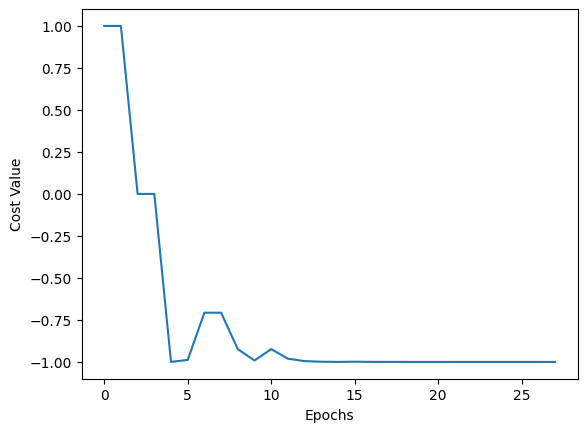

In [7]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

We see that the final value or our cost function, $\bra{\psi}Z\ket{\psi} = -1$ demonstrating that the qubit is in the $\ket{1}$ state.